In [2]:
# ! pip install scikit-image

from skimage.metrics import structural_similarity as ssim

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.jpeg_original import jpegenc, jpegdec

from scipy.optimize import minimize

In [4]:
# ------ relevant functions defined below ------

from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.dct import regroup, inverse_regroup
from cued_sf2_lab.dct import colxfm
from cued_sf2_lab.lbt import pot_ii

def pot(X, N, s = 1):

    Xp = X.copy() # copy the non-transformed edges directly from X
    Xc = X.copy()

    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T

    for i in range(256-N):
        for j in range(256-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]
    return Xc

def dct(X, N):
    cn = dct_ii(N)
    Y = colxfm(colxfm(X, cn).T, cn).T
    return Y

def dct_regroup(Y, N):
    Yr = regroup(Y, N)/N
    return Yr    

def dct_iregroup(Y, N):
    X = inverse_regroup(Y, N)
    return X

def idct(Y, N):
    cn = dct_ii(N)
    Zp = colxfm(colxfm(Y.T, cn.T).T, cn.T)
    return Zp

def ipot(Zp, N, s = 1):
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)

    Z = Zp
    Z2 = Zp
    Z = colxfm(Z[:,t].T,pr.T).T
    Z = colxfm(Z[t,:],pr.T)
    for i in range(256-N):
        for j in range(256-N):
            Z2[int(i+N/2),int(j+N/2)] = Z[i,j]
    return Z2

def lbt(X, N=8, s=1, step=17, k=0.5): # rise1 = step/2 by default, so k=0.5 by default
    Xp = pot(X, N, s)
    Y = dct(Xp, N)
    return Y

def ilbt(Yq, N=8, s=1):
    Zpq = idct(Yq, N)
    Zq = ipot(Zpq, N, s)
    return Zq

def full_process_results(X, N=8, s=1, step=17, k=0.5): 
    Y = lbt(X, N, s, step, k)
    Yq = quantise(Y, step, rise1=k*step)
    Zq = ilbt(Yq, N, s)

    rms = np.std(Zq-X)
    bits_Yq = bpp(Yq) * Yq.size
    bits_X = bpp(X) * X.size
    cr = bits_X / bits_Yq  

    return rms, cr

def dctbpp(Yr, N):
    # Your code here
    total_bits = 0
    d, d = np.shape(Yr)
    step = d//N
    for i in range(0, d, step):
        for j in range(0, d, step):
            Ys = Yr[i:i+step, j:j+step] 
            bits = bpp(Ys) * Ys.size
            total_bits += bits 
    return total_bits

# ----- finish ------

In [5]:
X, _ = load_mat_img('lighthouse.mat', img_info='X')
X = X - 128.0

RMS lbt once = 4.603935766800522
Bits needed = 94149.48275858701
RMS lbt twice = 5.501016431091299
Bits needed = 221094.97637811332


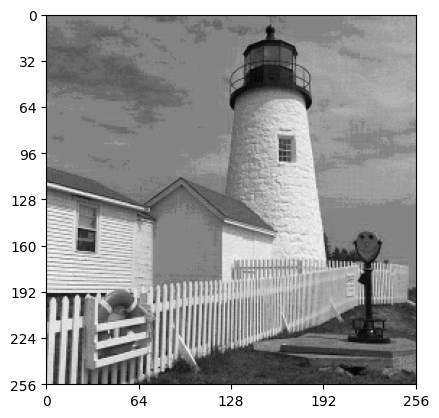

In [6]:
# ----- no regroup -----

step = 17

Y = lbt(X, N=4, s=1.31)
Yq = quantise(Y, step, step)
Z = ilbt(Yq, N=4, s=1.31)
print(f"RMS lbt once = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Yq)*Y.size}")

Y = lbt(X, N=4, s=1.31)
Y = lbt(Y, N=4, s=1.31)
Yq = quantise(Y, step, step)
Z = ilbt(Yq, N=4, s=1.31)
Z = ilbt(Z, N=4, s=1.31)
print(f"RMS lbt twice = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Yq)*Y.size}")

fig, ax = plt.subplots()
plot_image(Z)

RMS lbt once = 4.603935766800522
Bits needed = 94149.48275858701
RMS lbt twice with regroup = 38.29796398032031
Bits needed = 24559.20949629443


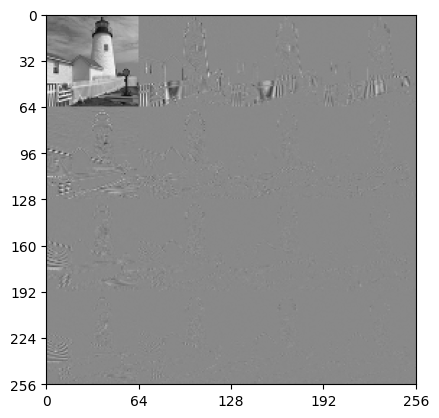

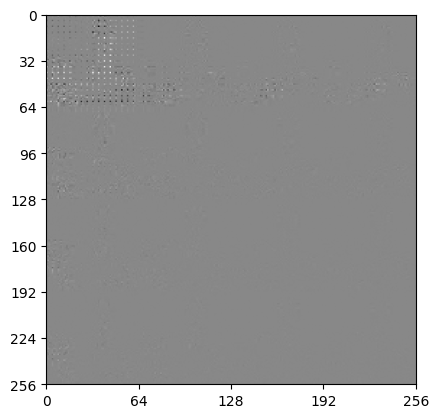

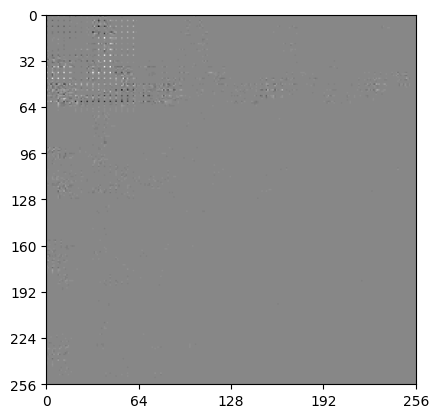

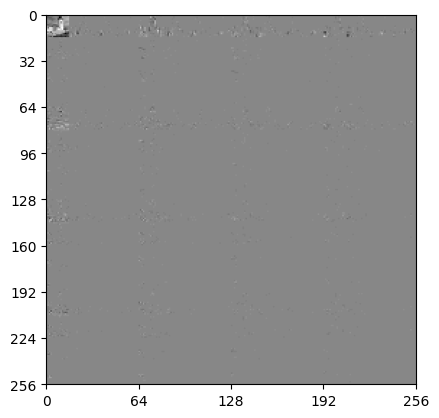

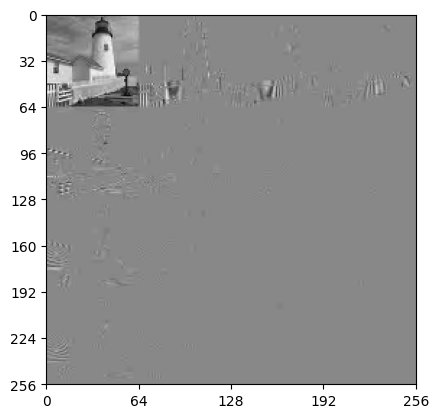

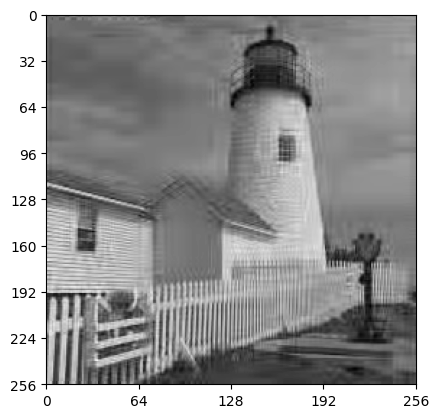

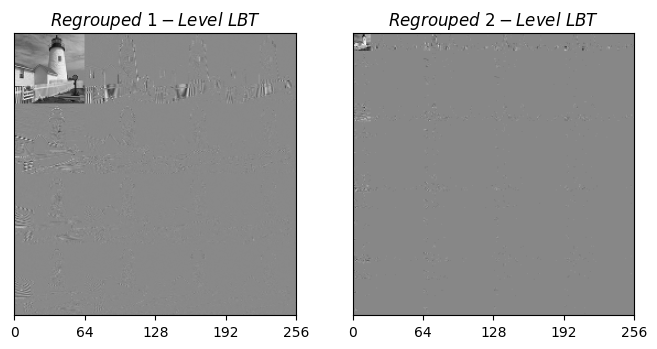

In [22]:
step = 17

Y = lbt(X, N=4, s=1.31)
Yq = quantise(Y, step, step)
Z = ilbt(Yq, N=4, s=1.31)
print(f"RMS lbt once = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Yq)*Y.size}")

Y = lbt(X, N=4, s=1.31)

Y = dct_regroup(Y, N=4)
Ysave1 = Y.copy()
# plot this
fig, ax = plt.subplots()
plot_image(Ysave1)

Y = lbt(Y, N=4, s=1.31)
# plot this
fig, ax = plt.subplots()
plot_image(Y)

Yq = quantise(Y, step, step)
# plot this
fig, ax = plt.subplots()
plot_image(Yq)

Yr = dct_regroup(Yq, N=4)
Ysave2 = Yr.copy()
# plot this
fig, ax = plt.subplots()
plot_image(Ysave2)

Z = ilbt(Yq, N=4, s=1.31)
# plot this
fig, ax = plt.subplots()
plot_image(Z)

Z = dct_iregroup(Z, N=4) 

Z = ilbt(Z, N=4, s=1.31)

print(f"RMS lbt twice with regroup = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Yq)*Y.size}")

fig, ax = plt.subplots()
plot_image(Z)


titles = ["Regrouped\ 1-Level\ LBT","Regrouped\ 2-Level\ LBT"]
imgs = [Ysave1, Ysave2]
fig, axs = plt.subplots(1, 2, figsize=(8, 4), 
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')
